## For Colabs

In [42]:
from getpass import getpass
import os

user = "OliverJBoom"
password = getpass('github password')

os.environ['GITHUB_AUTH'] = user + ':' + password
os.chdir("/content")
!rm -rf "/content/acse-9-independent-research-project-OliverJBoom"
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-9-independent-research-project-OliverJBoom.git
os.chdir("acse-9-independent-research-project-OliverJBoom/Src")

github password··········
Cloning into 'acse-9-independent-research-project-OliverJBoom'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 543 (delta 62), reused 51 (delta 22), pack-reused 446
Receiving objects: 100% (543/543), 9.03 MiB | 24.93 MiB/s, done.
Resolving deltas: 100% (300/300), done.


In [2]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
path = "/content/gdrive/My Drive/Chai/Data"

Mounted at /content/gdrive/


## Loading Packages

In [1]:
from deeplearning import *
from models import *
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pickle
from preprocessing import *
from statistics import median
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from utils import *
import warnings

warnings.filterwarnings("ignore")

set_seed(42)

/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


True

### Insuring that training is done on GPU if available

In [2]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


## Loading Data

In [3]:
path = "Data/Commodity_Data/"
universe_dict = universe_select(path, "MTL")
use_lg_returns = False

## Preprocessing

In [4]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)

# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)

# Making sure that all the points in the window have consistent length
universe_dict = truncate_window_length(universe_dict)

# # Generating the dataset
if use_lg_returns:
    # Lg Returns Only
    df_full = generate_dataset(universe_dict, lg_returns_only=True, price_only=False)
    target_col = ["cu_lme", "al_lme", "sn_lme", "pb_lme", "ni_lme"]
    
else:
    # Price Only
    df_full = generate_dataset(universe_dict, lg_returns_only=False, price_only=True)
    target_col = ["price_cu_lme", "price_al_lme", "price_sn_lme", "price_pb_lme", "price_ni_lme"]

# Set to False initially
PCA_used = False

Included Instrument:
al_shfe
al_lme
al_comex_p
Rows removed: 1
al_comex_s
al_lme_s
yuan
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci
sn_lme
pb_lme
ni_lme


In [5]:
# Visualise the plots
# visualise_universe(universe_dict)

In [6]:
df_full.head(15)
# df_full.tail(5)

,price_al_shfe,price_al_lme,price_al_comex_p,price_al_comex_s,price_al_lme_s,price_yuan,price_cu_shfe,price_cu_lme,price_cu_comex_p,price_cu_comex_s,price_peso,price_sol,price_bdi,price_ted,price_vix,price_skew,price_gsci,price_sn_lme,price_pb_lme,price_ni_lme
date,,,,,,,,,,,,,,,,,,,,
2014-06-04,13270.0,1812.75,2189.75,13403.0,5170375.0,6.2494,49570.0,6834.0,3.0935,16395.0,552.09,2.7890,959.0,0.0355,12.08,121.48,645.9893,23225.0,2103.0,19025.0
2014-06-05,13235.0,1824.25,2201.00,13852.0,5160575.0,6.2548,49520.0,6803.0,3.0910,16440.0,550.66,2.7890,977.0,0.0355,11.68,122.21,646.6336,23245.0,2109.0,19030.0
2014-06-06,13280.0,1856.75,2222.25,14276.0,5152975.0,6.2498,49550.0,6696.0,3.0530,16323.0,549.03,2.7890,989.0,0.0330,10.73,122.88,646.6281,23195.0,2109.0,18875.0
2014-06-09,13385.0,1886.00,2257.00,14876.0,5146525.0,6.2397,48720.0,6688.5,3.0455,16183.0,549.65,2.7830,999.0,0.0355,11.15,124.67,651.2814,23295.0,2141.0,18905.0
2014-06-10,13455.0,1865.50,2250.75,15138.0,5140000.0,6.2240,48420.0,6710.0,3.0550,16320.0,553.49,2.7890,1004.0,0.0406,10.99,125.38,648.0516,22865.0,2140.0,18775.0
2014-06-11,13470.0,1827.00,2222.25,15701.0,5131675.0,6.2277,48480.0,6743.0,3.0420,16807.0,554.70,2.7970,973.0,0.0380,11.60,126.71,647.5428,22850.0,2125.0,18305.0
2014-06-12,13365.0,1803.75,2183.00,16209.0,5127100.0,6.2175,48560.0,6643.5,3.0170,17297.0,553.47,2.7935,939.0,0.0380,12.56,127.82,658.5549,22575.0,2075.0,18000.0
2014-06-13,13285.0,1803.75,2190.25,16667.0,5118150.0,6.2090,48860.0,6679.5,3.0305,17407.0,555.89,2.7870,906.0,0.0355,12.18,127.78,660.4576,22605.0,2086.0,18070.0
2014-06-16,13310.0,1809.25,2206.75,16655.0,5109600.0,6.2250,49390.0,6718.5,3.0470,17654.0,554.67,2.7950,880.0,0.0304,12.65,127.67,661.3156,22450.0,2106.0,18650.0


### Normalizing the dataset

In [7]:
# Forecast length
forecast_length = 22

# Data scaling
scaler_data_X = MinMaxScaler()
scaler_data_y = MinMaxScaler()

df_target = df_full[target_col]

data_X = scaler_data_X.fit_transform(df_full)[:-forecast_length, :]
# Need to have an independent scaler for inverse_transforming later
data_y = scaler_data_y.fit_transform(df_target)

# Offset target one forecast length
data_y = data_y[forecast_length:, :]

### PCA

In [8]:
# Reducing the dataset to containing a threshold amount of variance
n_dim = dimension_selector(data_X, thresh=0.95)
data_X = dimension_reduce(data_X, n_dim)

PCA_used = True

print("data_X ", data_X.shape, "data_y ", data_y.shape)

Number of dimensions: 7
Explained Variance: [0.47823784 0.28403175 0.08399456 0.04503531 0.02831453 0.01764623
 0.01449351] 
Explained Variance Sum: 0.9517537202406412
data_X  (1293, 7) data_y  (1293, 5)


### Slicing Series into Windows

In [9]:
# The input size of each time series window
series_length = 250
  
data_X, data_y = slice_series(data_X, data_y, series_length, dataset_pct=0.5)
print("data_X ", data_X.shape, "data_y ", data_y.shape)

data_X  (396, 250, 7) data_y  (396, 5)


### Hyperparameters

In [10]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 32
test_batch_size = 1000
# series_length = 100

# Training Parameters
n_epochs = 1000
patience = 100
disp_freq=10
fig_disp_freq=20


# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 128
hidden_dim_2 = 8
num_layers = 2
output_dim = data_y.shape[1]
dropout = 0.1

### Initialising the model

In [11]:
model_mtl = LSTM_deep(num_features=num_features, 
             hidden_dim=hidden_dim, 
             hidden_dim_2=hidden_dim_2,
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device,
             dropout=dropout)

model_mtl.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 7 
hidden_dim 128
series_length 250 
batch_size 32
output_dim 5 
num_layers 2
data_X  (396, 250, 7) 
data_y (396, 5)


In [12]:
# Loading trained model
# model = torch.load("/content/gdrive/My Drive/Chai/Models/Pths/" + "partial_dataset_LSTM_0_1206.pth")
# model.to(device)

Epoch: 0 Train: 9.63918 Val: 7.85270  Time: 17.486  Best Val: 7.85270


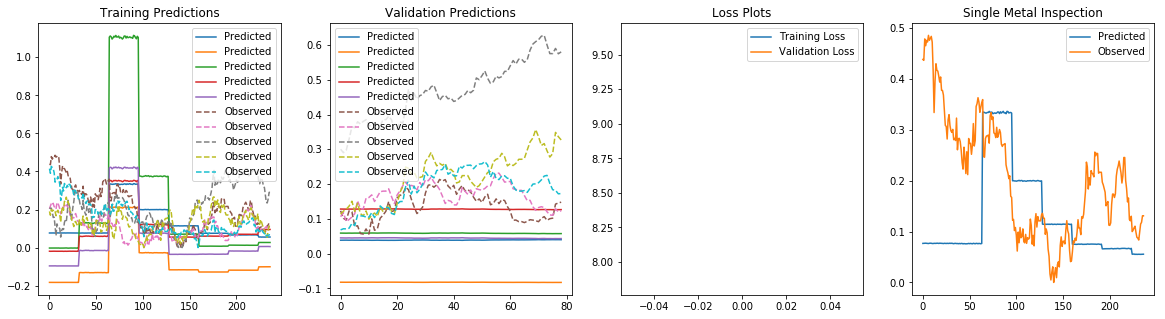

Epoch: 1 Train: 3.53964 Val: 4.54214  Time: 23.628  Best Val: 4.54214


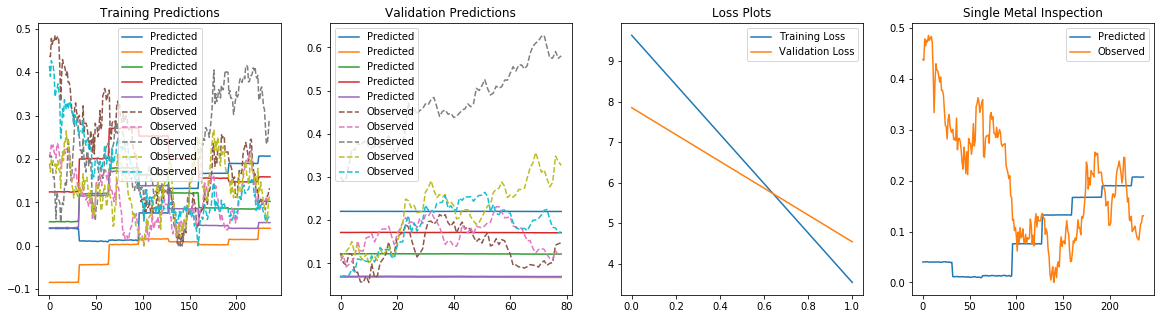

Epoch: 2 Train: 2.19931 Val: 3.78774  Time: 28.696  Best Val: 3.78774


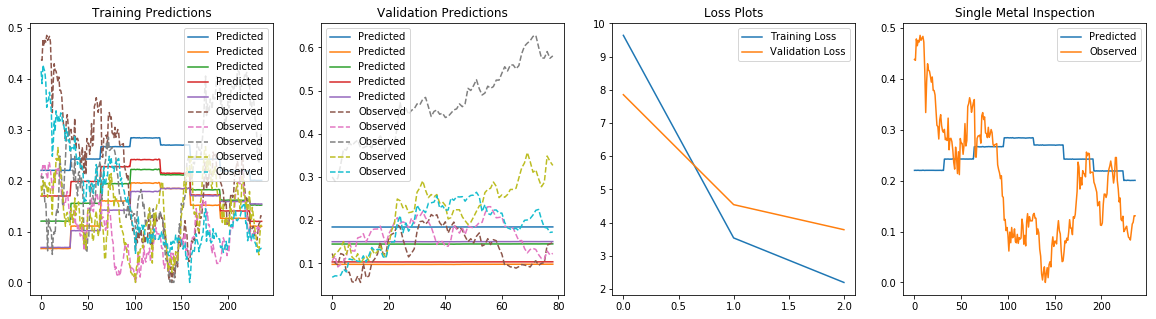

Epoch: 3 Train: 1.49382 Val: 3.23494  Time: 33.733  Best Val: 3.23494


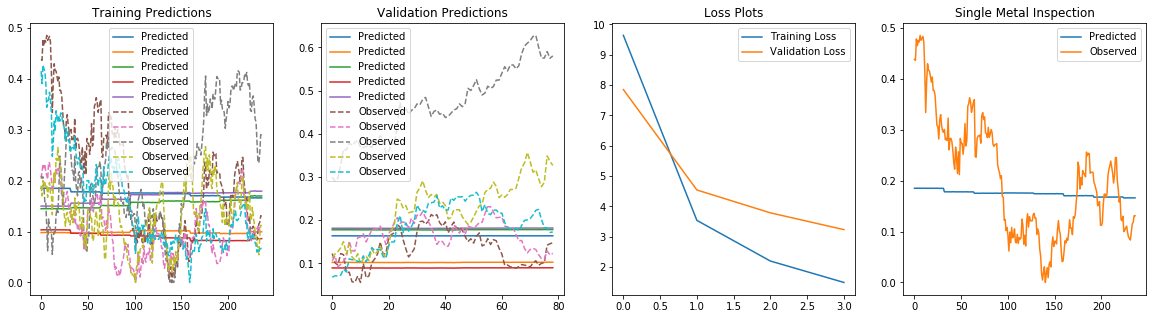

Epoch: 4 Train: 1.47858 Val: 2.69047  Time: 38.789  Best Val: 2.69047


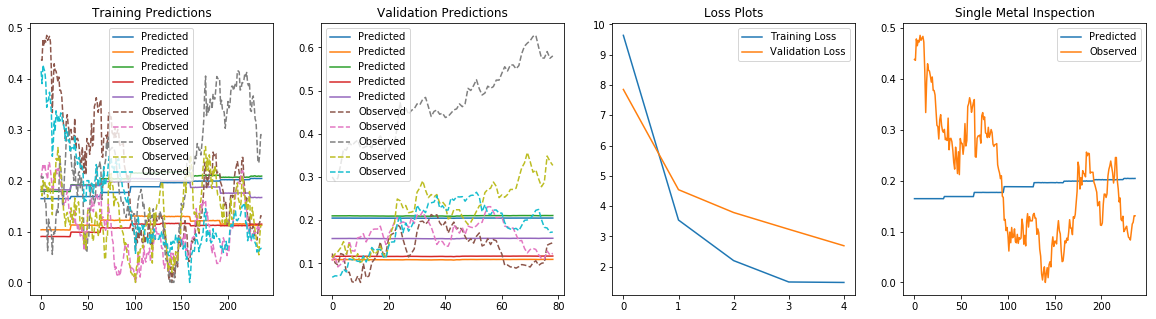

Epoch: 5 Train: 1.34128 Val: 2.75781  Time: 43.765  Best Val: 2.69047


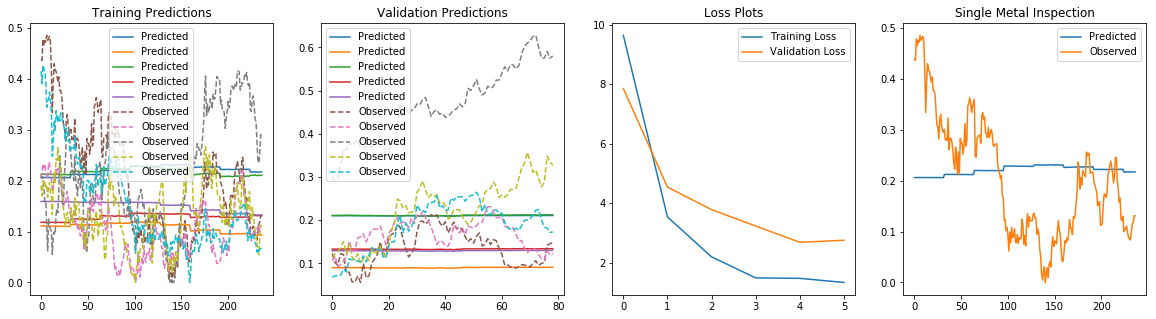

Epoch: 6 Train: 1.33151 Val: 2.54194  Time: 48.828  Best Val: 2.54194


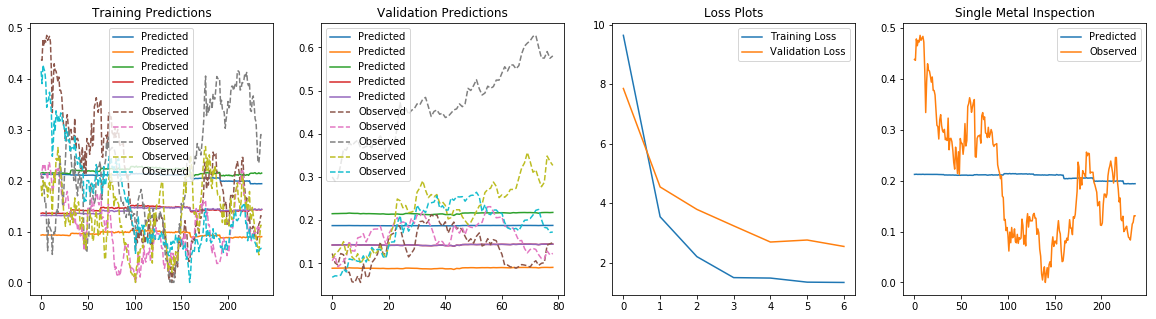

Epoch: 7 Train: 1.34806 Val: 2.60765  Time: 54.128  Best Val: 2.54194


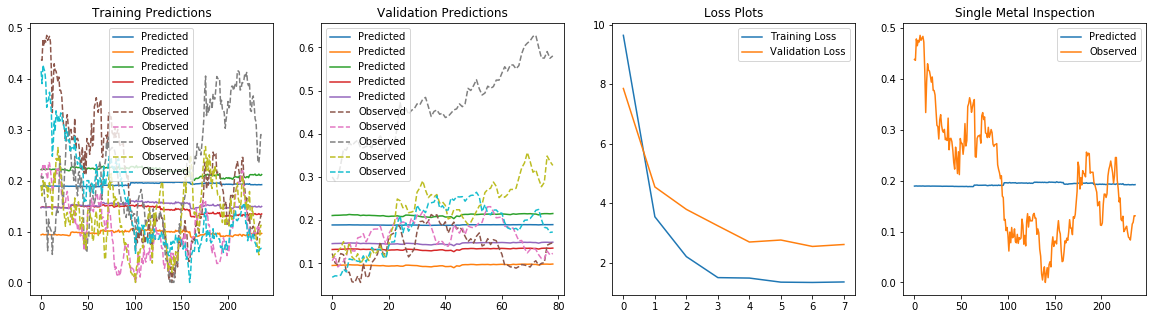

Epoch: 8 Train: 1.31606 Val: 2.50442  Time: 59.994  Best Val: 2.50442


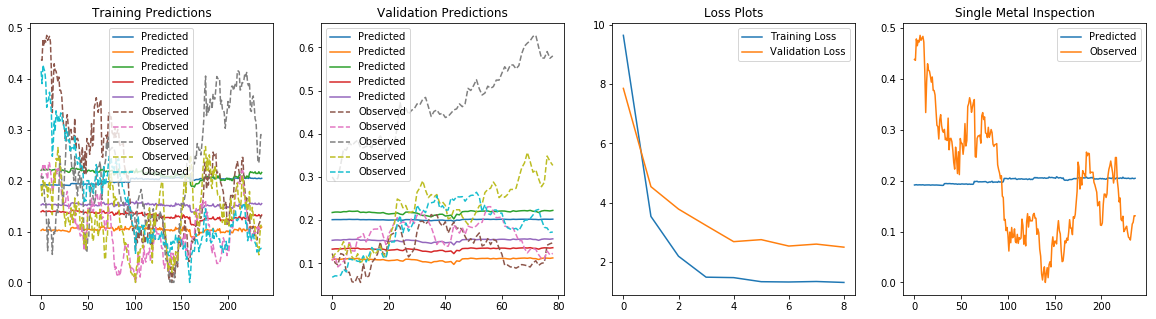

Epoch: 9 Train: 1.22587 Val: 2.27055  Time: 67.002  Best Val: 2.27055


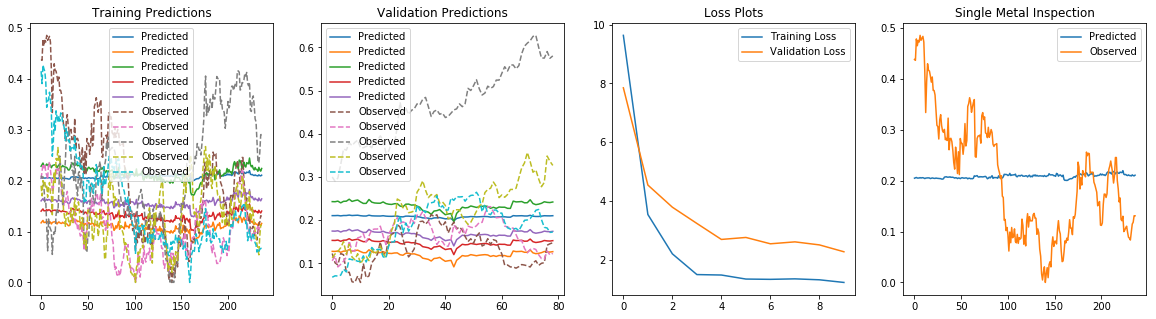

Epoch: 10 Train: 1.14312 Val: 2.46990  Time: 74.157  Best Val: 2.27055


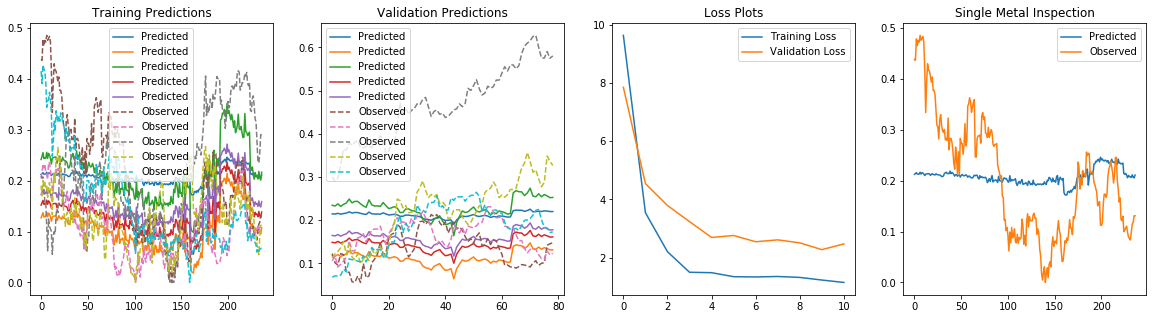

Epoch: 11 Train: 1.23715 Val: 3.81211  Time: 79.926  Best Val: 2.27055


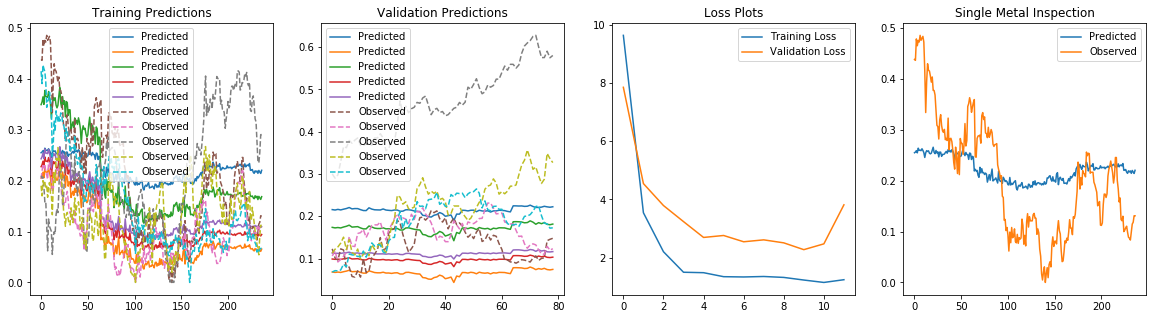

Epoch: 12 Train: 1.19722 Val: 2.33689  Time: 85.677  Best Val: 2.27055


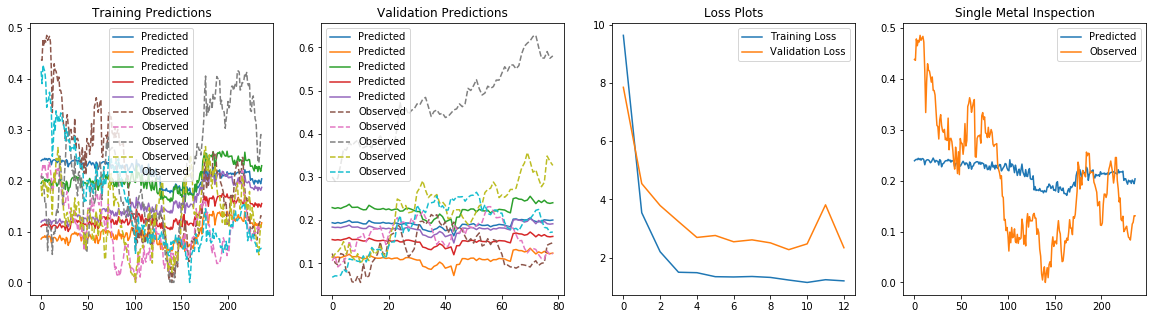

Epoch: 13 Train: 0.97155 Val: 2.27800  Time: 91.756  Best Val: 2.27055


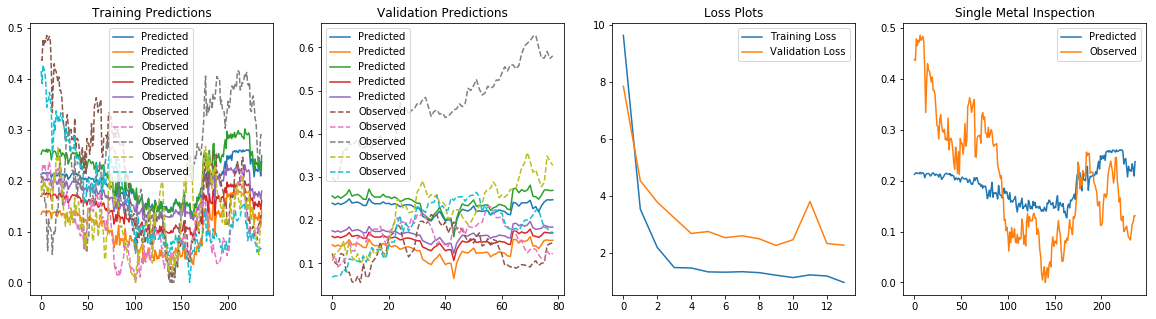

Epoch: 14 Train: 0.98376 Val: 2.19630  Time: 97.634  Best Val: 2.19630


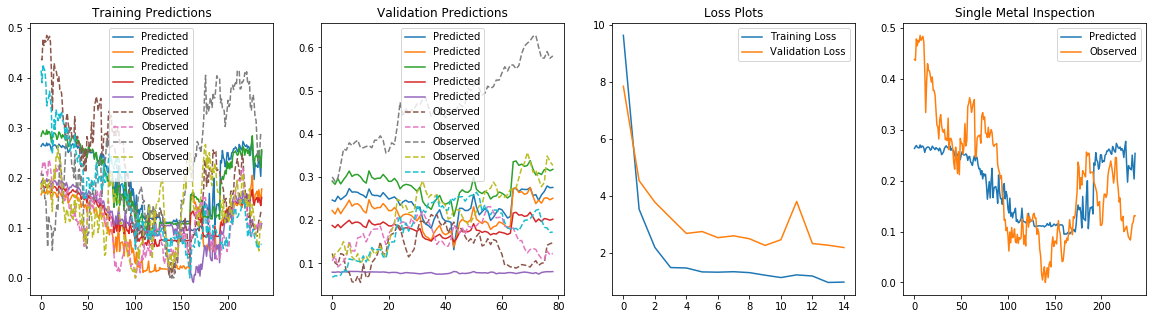

Epoch: 15 Train: 1.51206 Val: 3.16769  Time: 104.030  Best Val: 2.19630


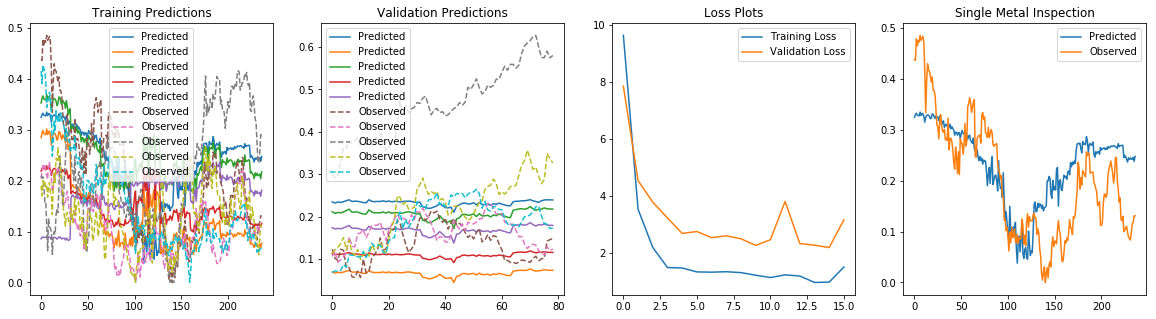

Epoch: 16 Train: 1.19537 Val: 2.73222  Time: 110.091  Best Val: 2.19630


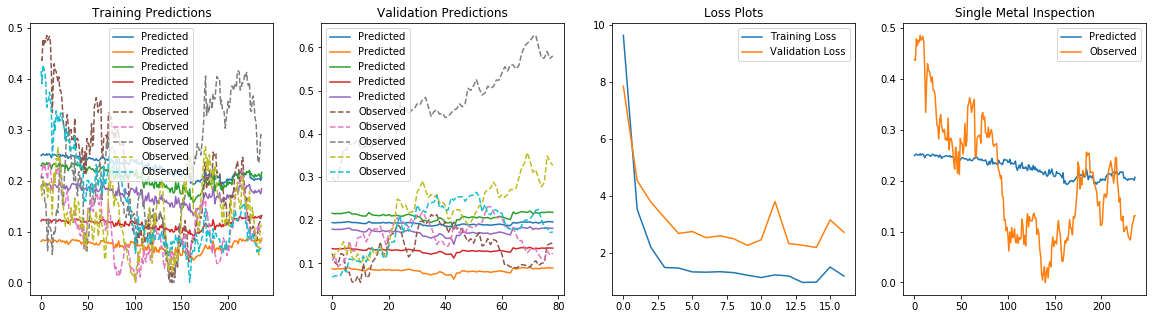

Epoch: 17 Train: 1.12157 Val: 2.85899  Time: 116.083  Best Val: 2.19630


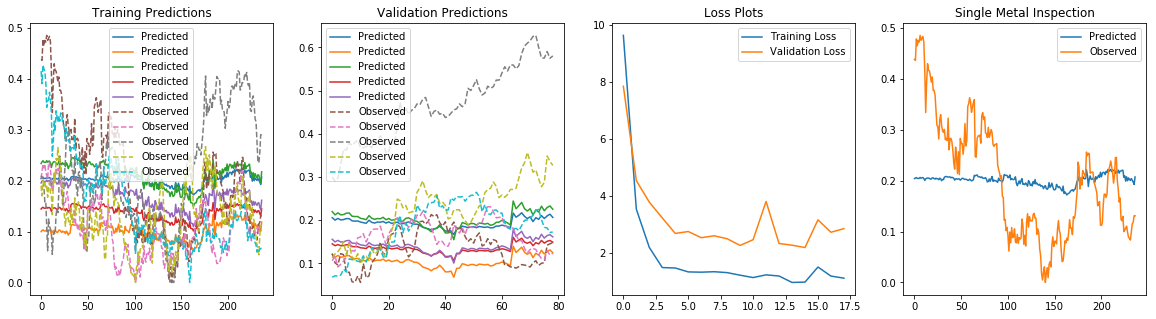

Epoch: 18 Train: 0.99488 Val: 3.03245  Time: 122.059  Best Val: 2.19630


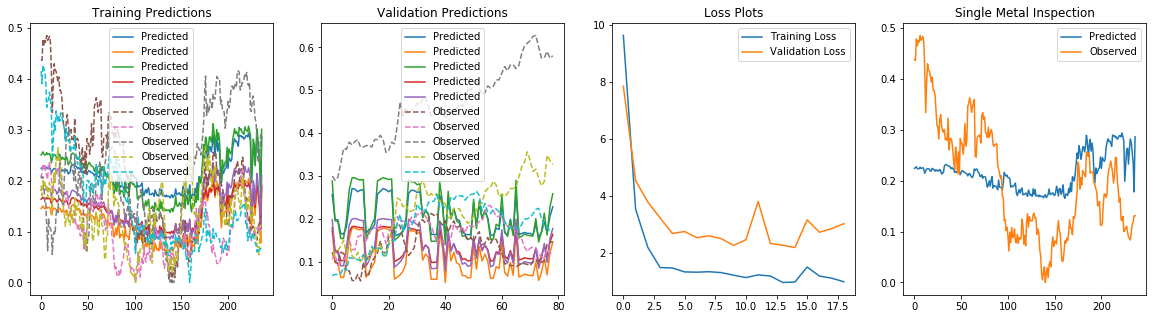

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3

KeyboardInterrupt: 

In [15]:
optimiser = torch.optim.Adam(model_mtl.parameters(), learning_rate)

"""Do I need to declare a data explicitly in the dataset"""
learning = DeepLearning(model=model_mtl, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=n_epochs,
                        optimiser=optimiser,
                        batch_size=batch_size,
                        debug=False, 
                        disp_freq=1,
                        fig_disp_freq=1, 
                        device=device,
                        patience=patience)

# Splitting the data into the train, validation and test sets
learning.train_val_test()
learning.training_wrapper()
print("Best Score:", learning.best_val_score)

In [16]:
learning.evaluate(learning.best_model, learning.test_loader)

NameError: name 'val_pred_list' is not defined

In [28]:
print(learning.logs["Validation Loss"])

[0.2983059023799829, 0.34804055379052046, 0.2778151405994968, 0.31234917623836667, 0.27542434901314994, 0.2736624550903644, 0.27404202336557343, 0.2706574517509541, 0.29177542878545215, 0.30146419707119676, 0.30523663611799584, 0.3095004533289178, 0.2417525857581688, 0.23790857143199906, 0.2474016165986078, 0.2464072283080947]


### Saving Model Object

In [0]:
model_name = "log_returns_" + forecast_length
obj_name = "Learning" + "_" + model_name
pickle.dump(learning, open("/content/gdrive/My Drive/Chai/Models/Pickles/" + obj_name, 'wb'))

In [0]:
# learning_load = pickle.load(open("/content/gdrive/My Drive/Chai/Models/Pickles/" + "learning_object", 'rb'))

In [45]:
model_save(model, 
           path="/content/gdrive/My Drive/Chai/Models/Pths/",
           name= "LSTM" + model_name, 
           val_score=learning.best_val_score)

# mod = model_load(path="Models/Pths",
#            model_name="LSTM_5_854")

Saving model: /content/gdrive/My Drive/Chai/Models/Pths/LSTMlog_returns_0_2379.pth


### Plotting

In [0]:
# Scaled Observed
train_true = scaler_data_y.inverse_transform(learning.y_train.numpy().reshape(-1, 1))
val_true  = scaler_data_y.inverse_transform(learning.y_val.numpy().reshape(-1, 1))
test_true  = scaler_data_y.inverse_transform(learning.y_test.numpy().reshape(-1, 1))

# Scaled Predicted
train_pred = scaler_data_y.inverse_transform(np.array(learning.train_predictions).reshape(-1, 1))
val_pred  = scaler_data_y.inverse_transform(np.array(learning.val_predictions).reshape(-1, 1))
test_pred = scaler_data_y.inverse_transform(np.array(learning.test_predictions).reshape(-1, 1))

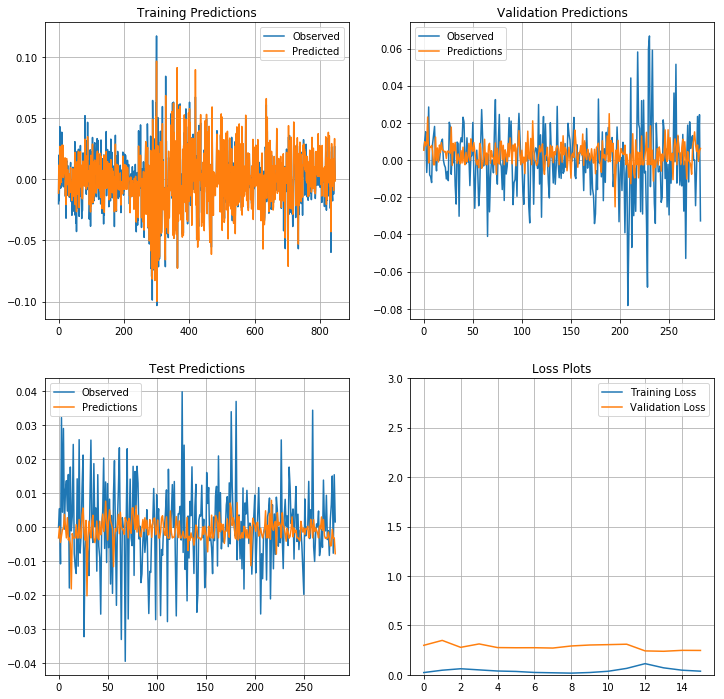

In [36]:
# Rescaling Example
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

ax[0, 0].set_title("Training Predictions")
ax[0, 0].plot(train_true, label="Observed")
ax[0, 0].plot(train_pred, label="Predicted")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].grid()
ax[0, 1].set_title("Validation Predictions")
ax[0, 1].plot(val_true, label="Observed")
ax[0, 1].plot(val_pred, label="Predictions")
ax[0, 1].legend()

ax[1, 0].grid()
ax[1, 0].set_title("Test Predictions")
ax[1, 0].plot(test_true, label="Observed")
ax[1, 0].plot(test_pred, label="Predictions")
ax[1, 0].legend()

ax[1, 1].grid()
ax[1, 1].set_title("Loss Plots")
ax[1, 1].plot(learning.logs['Training Loss'], label="Training Loss")
ax[1, 1].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[1, 1].legend()
ax[1, 1].set_ylim((0, 3))

epoch_reached = str(len(learning.logs['Training Loss']))
path="/content/gdrive/My Drive/Chai/Models/"
val_loss = learning.best_val_score

plt.savefig(path + model_name + str("LSTM_Val_" + str(val_loss)[:5].replace(".", "_") + "_Epoch_" + epoch_reached + ".png"))

plt.show()

# Results

In [0]:
# test_increase = 1e-5 * np.array(range(test_pred.shape[0]))

In [0]:
test_zeros = np.zeros(test_pred.shape)

In [63]:
mse, mae, mde = evaluate(test_pred, test_true)
print(mse, mae, mde)
mse_zeros, mae_zeros, mde_zeros = evaluate(test_zeros, test_true)
print(mse_zeros, mae_zeros, mde_zeros)

mse_increase, mae_increase, mde_increase = evaluate(test_increase, test_true)
print(mse_increase, mae_increase, mde_increase)

0.00016841677 0.009820792 0.4734982332155477
0.00015301969940381452 0.009199581665482485 0.0
0.00015491493001170347 0.009353009683091619 0.5246413365131292


In [0]:
# The minimum validation loss
best_model_epoch = learning.logs['Validation Loss'].index(val_loss)
train_loss = learning.logs['Training Loss'][best_model_epoch]
test_loss = learning.evaluate(learning.best_model, learning.test_loader)

In [64]:
num_epoch = 250
train_time = learning.logs["Time"]
full_save(learning.best_model, 
          model_name,
          optimiser,
          num_epoch, 
          learning_rate, 
          momentum,
          weight_decay, 
          use_lg_returns,
          PCA_used, 
          data_X,
          train_loss,
          val_loss, 
          test_loss,
          train_time, 
          hidden_dim,
          mse,
          mae,
          mde,
          path="/content/gdrive/My Drive/Chai/Models/CSVs/") 

NameError: ignored

## Persistance

In [0]:
plt.title("Persistance vs Observed Values")
plt.plot(learning.train_predictions, label="Predicted")
plt.plot(shift(learning.train_predictions, 5), label="Observed")
plt.legend()

In [0]:
df = df_full[["target"]]
# Taking t-1 to be the value for t
df["persistance"] = df.shift(1)
df.dropna(inplace=True)
# Calculating metrics for these columns
MSE, MAE, MDE = evaluate(df, "target", "persistance")

In [0]:
print(df[:5])
print(df[-5:])

In [0]:
# Placing in results dataframe
results = pd.DataFrame(columns={"MSE", "MAE", "MDE"})
results.index.name = 'Name'
results.head()
results.loc["persistance"] = [MSE, MAE, MDE] 
results.head()